![image.png](https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [5]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define the target size for resizing
target_size = (256, 256)

# Image transformations
image_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Mask transformations (normalized to [0, 1])
mask_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])

# Data directories
train_image_dir = '/content/drive/MyDrive/img-seg/TrainDataset/images'
train_mask_dir = '/content/drive/MyDrive/img-seg/TrainDataset/masks'
test_image_dir = '/content/drive/MyDrive/img-seg/TestDataset/images'
test_mask_dir = '/content/drive/MyDrive/img-seg/TestDataset/masks'

# Datasets and Dataloaders
train_dataset = SegmentationDataset(train_image_dir, train_mask_dir, image_transform, mask_transform)
test_dataset = SegmentationDataset(test_image_dir, test_mask_dir, image_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# U-NET MODEL

In [7]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

# Instantiate the model
model = UNet().to('cuda' if torch.cuda.is_available() else 'cpu')


# Training

In [ ]:
import torch.optim as optim


save_path = '/content/drive/MyDrive/model_weights/'

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

# After the training loop, save the weights from the last epoch
torch.save(model.state_dict(), os.path.join(save_path, 'last_epoch_weights.pth'))
print("Training complete.")

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_weights_path = '/content/drive/MyDrive/Computer_vision_project/last_epoch_weights.pth'
model.load_state_dict(torch.load(unet_weights_path, map_location=device))
model.eval()

<ipython-input-9-322cf9fed3bd>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(unet_weights_path, map_location=device))


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=

In [10]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = model(images)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()

    fig, axes = plt.subplots(len(images), 3, figsize=(15, 5 * len(images)))
    for i in range(len(images)):
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[0, 0].set_title('Input Image')
        axes[i, 1].imshow(masks[i, 0], cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[i, 2].imshow(outputs[i, 0], cmap='gray')
        axes[0, 2].set_title('Prediction')
    plt.show()

visualize_predictions(model, test_loader, device)


Output hidden; open in https://colab.research.google.com to view.

# **Segmentation Metrics Implementation**



In [13]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import directed_hausdorff

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-15) / (np.sum(y_true) + np.sum(y_pred) + 1e-15)

def iou_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-15) / (union + 1e-15)

def hausdorff_distance(y_true, y_pred):
    y_true_points = np.array(np.where(y_true)).T
    y_pred_points = np.array(np.where(y_pred)).T

    if len(y_true_points) == 0 or len(y_pred_points) == 0:
        return 0  # Return 0 if either mask is empty

    return max(directed_hausdorff(y_true_points, y_pred_points)[0],
               directed_hausdorff(y_pred_points, y_true_points)[0])

def evaluate_segmentation(model, dataloader, device, threshold=0.5):
    model.eval()
    dice_scores = []
    iou_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    hausdorff_distances = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)

            # Ensure masks are binary
            masks = (masks > 0.5).cpu().numpy().astype(np.int64)

            # Convert model outputs to binary predictions
            predictions = (outputs > threshold).cpu().numpy().astype(np.int64)

            for true, pred in zip(masks, predictions):
                true = true.squeeze()
                pred = pred.squeeze()

                # Ensure true and pred have the same shape
                if true.shape != pred.shape:
                    pred = pred[:true.shape[0], :true.shape[1]]

                dice_scores.append(dice_coefficient(true, pred))
                iou_scores.append(iou_score(true, pred))
                accuracy_scores.append(accuracy_score(true.flatten(), pred.flatten()))
                precision_scores.append(precision_score(true.flatten(), pred.flatten(), zero_division=1))
                recall_scores.append(recall_score(true.flatten(), pred.flatten(), zero_division=1))
                f1_scores.append(f1_score(true.flatten(), pred.flatten(), zero_division=1))
                hausdorff_distances.append(hausdorff_distance(true, pred))

    return {
        'Dice': np.mean(dice_scores),
        'IoU': np.mean(iou_scores),
        'Accuracy': np.mean(accuracy_scores),
        'Precision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1': np.mean(f1_scores),
        'Hausdorff Distance': np.mean(hausdorff_distances)
    }

# Usage
model.to(device)
metrics = evaluate_segmentation(model, test_loader, device)
for metric, value in metrics.items():
    print(f'{metric}: {value:.4f}')

Dice: 0.7875
IoU: 0.6967
Accuracy: 0.9451
Precision: 0.8530
Recall: 0.8002
F1: 0.7975
Hausdorff Distance: 44.9705


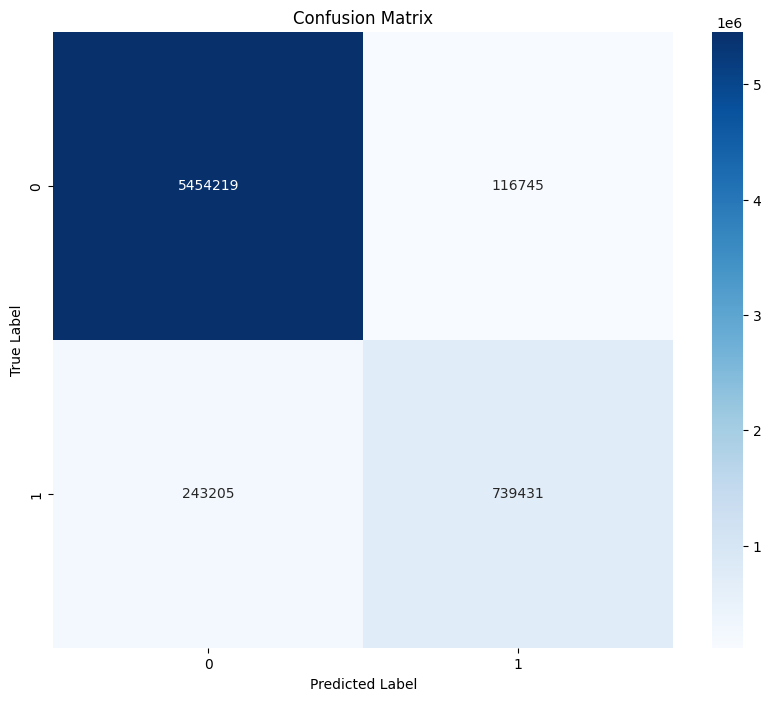

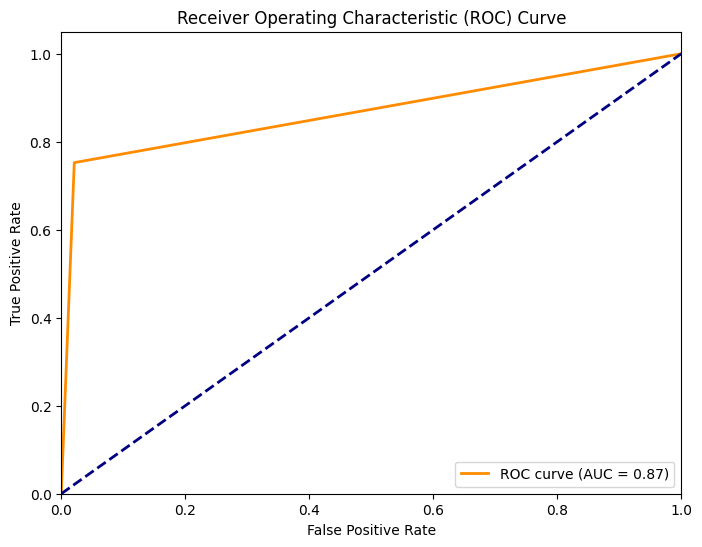

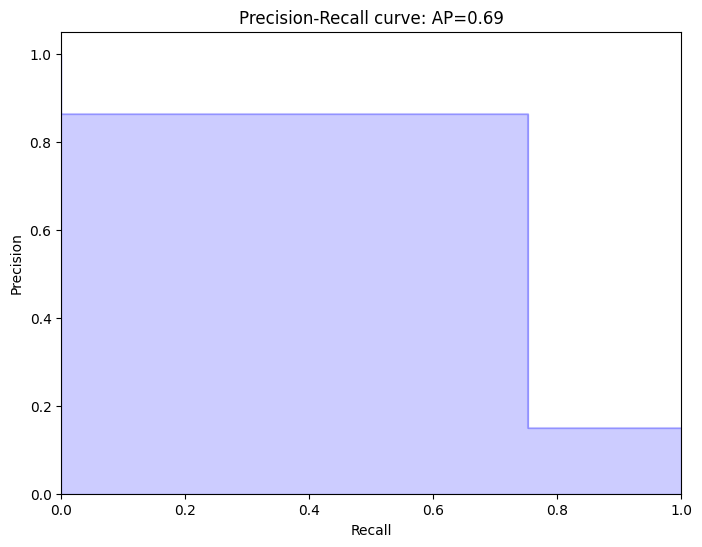

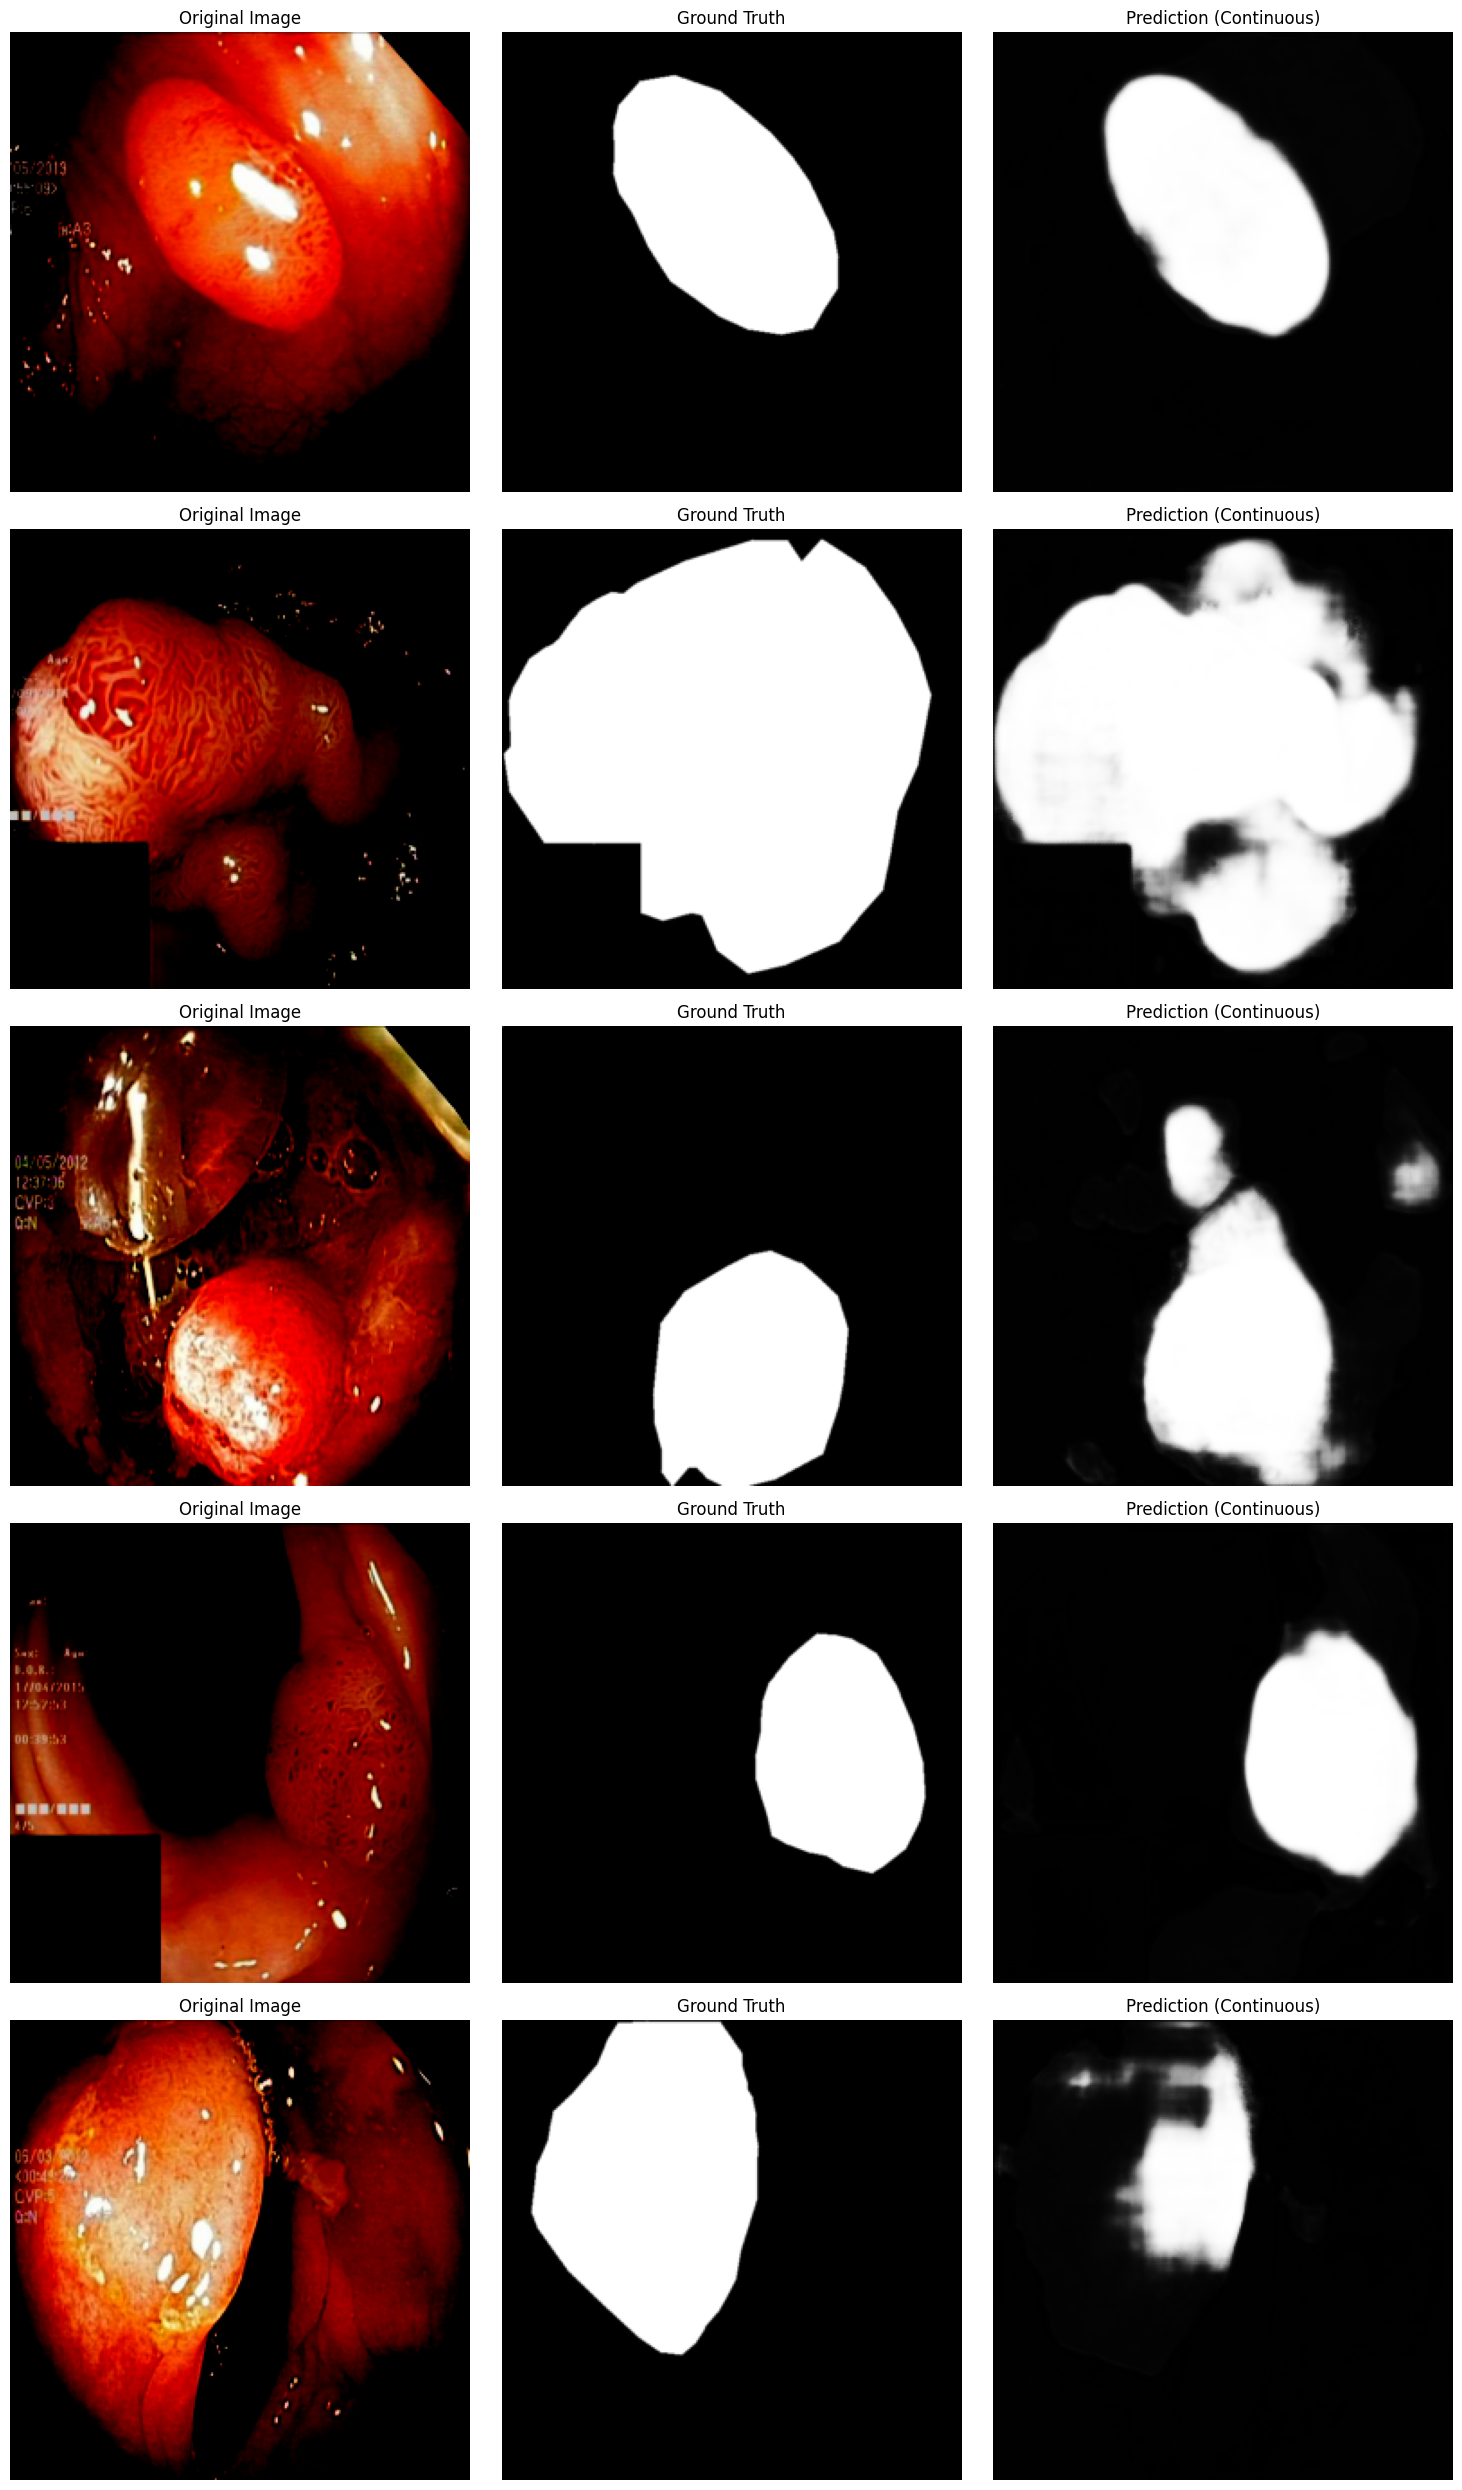

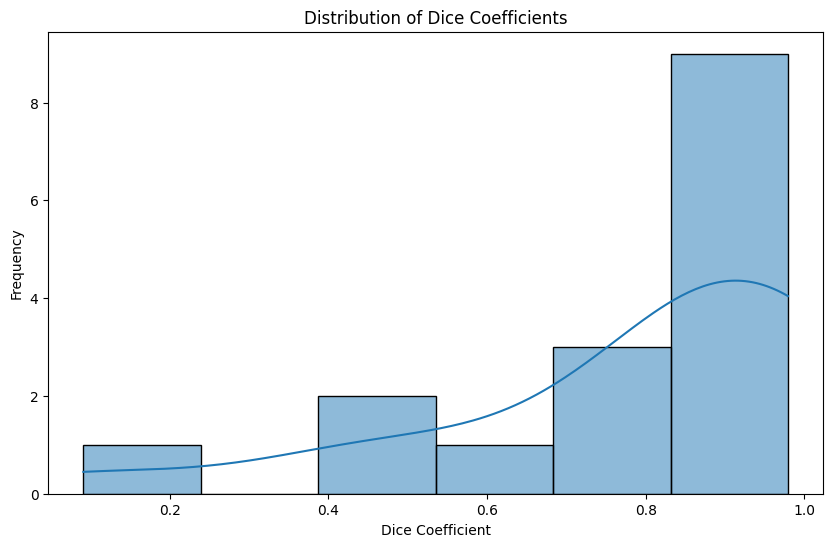

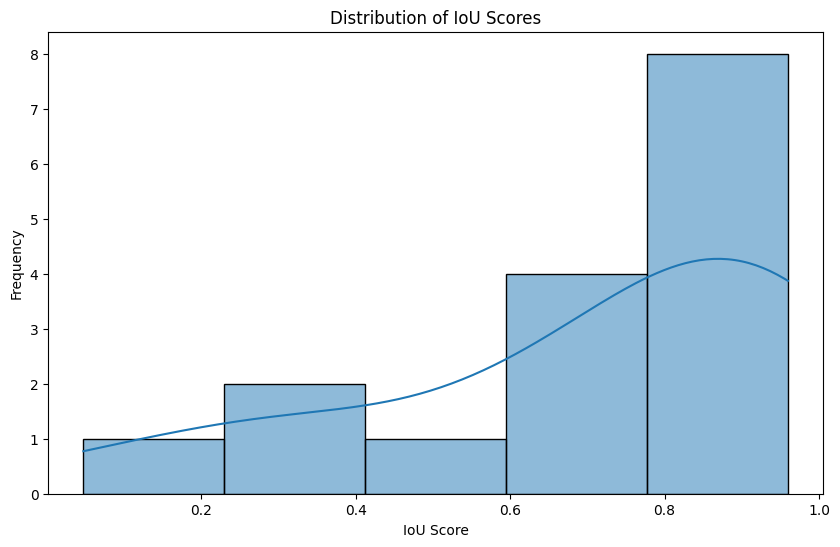

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

def visualize_segmentation_results(model, test_loader, device, threshold=0.5, num_samples=5):
    model.eval()
    all_preds = []
    all_truths = []
    sample_images = []
    sample_masks = []
    sample_preds = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)

            # Convert continuous outputs to binary predictions
            preds = (outputs > threshold).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_truths.extend(masks.cpu().numpy().flatten())

            if len(sample_images) < num_samples:
                sample_images.extend(images.cpu().numpy())
                sample_masks.extend(masks.cpu().numpy())
                sample_preds.extend(outputs.cpu().numpy())

    # Ensure all_preds and all_truths are binary
    all_preds = np.array(all_preds) > threshold
    all_truths = np.array(all_truths) > 0.5

    # Confusion Matrix
    cm = confusion_matrix(all_truths, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_truths, all_preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_truths, all_preds)
    average_precision = average_precision_score(all_truths, all_preds)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
    plt.show()

    # Sample Predictions
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Handle grayscale images
        if sample_images[i].shape[0] == 1:
            img = sample_images[i].squeeze()
        else:
            img = np.transpose(sample_images[i], (1, 2, 0))

        mask = sample_masks[i].squeeze()
        pred = sample_preds[i].squeeze()

        axes[i, 0].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Prediction (Continuous)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Dice Coefficient Distribution
    dice_scores = [dice_coefficient(mask.squeeze() > 0.5, pred.squeeze() > threshold)
                   for mask, pred in zip(sample_masks, sample_preds)]
    plt.figure(figsize=(10, 6))
    sns.histplot(dice_scores, kde=True)
    plt.title('Distribution of Dice Coefficients')
    plt.xlabel('Dice Coefficient')
    plt.ylabel('Frequency')
    plt.show()

    # IoU Distribution
    iou_scores = [iou_score(mask.squeeze() > 0.5, pred.squeeze() > threshold)
                  for mask, pred in zip(sample_masks, sample_preds)]
    plt.figure(figsize=(10, 6))
    sns.histplot(iou_scores, kde=True)
    plt.title('Distribution of IoU Scores')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')
    plt.show()

# Helper functions
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-15) / (np.sum(y_true) + np.sum(y_pred) + 1e-15)

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / (np.sum(union) + 1e-15)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

visualize_segmentation_results(model, test_loader, device)

# UNET++

In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNetPlusPlus, self).__init__()

        features = init_features
        self.encoder1 = UNetPlusPlus._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetPlusPlus._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNetPlusPlus._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNetPlusPlus._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNetPlusPlus._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNetPlusPlus._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNetPlusPlus._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNetPlusPlus._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNetPlusPlus._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.nest1 = UNetPlusPlus._nest_block(features * 2, features, name="nest1")
        self.nest2 = UNetPlusPlus._nest_block(features * 4, features * 2, name="nest2")
        self.nest3 = UNetPlusPlus._nest_block(features * 8, features * 4, name="nest3")
        self.nest4 = UNetPlusPlus._nest_block(features * 16, features * 8, name="nest4")

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = torch.sigmoid(self.conv(dec1))
        return out

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def _nest_block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

# Instantiate the model
model = UNetPlusPlus().to('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

print("Training complete.")


In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)
    with torch.no_grad():
        outputs = model(images)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()

    fig, axes = plt.subplots(len(images), 3, figsize=(15, 5 * len(images)))
    for i in range(len(images)):
        # Clip and normalize images for display
        img = np.transpose(images[i], (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())

        mask = masks[i, 0]
        output = outputs[i, 0]

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(output, cmap='gray')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device)


In [ ]:
visualize_predictions(model, test_loader, device)